**Import Necessary Libraries**

In [3]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import keras
from keras.utils.np_utils import to_categorical
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.layers import  Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from keras.models import Model
from keras import optimizers
from tensorflow.keras.optimizers import Adam
from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from keras import callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
%tensorflow_version 2.x
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

UsageError: Line magic function `%tensorflow_version` not found.


**Split Into Train Data & Test Data**

In [9]:
disease_types=['COVID', 'non-COVID']
data_dir = r'D:\FYPProject\Dataset'
train_dir = os.path.join(data_dir)

In [10]:
train_data = []
for defects_id, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train_data.append(['{}/{}'.format(sp, file), defects_id, sp])      
train = pd.DataFrame(train_data, columns=['File', 'DiseaseID','Disease Type'])

In [11]:
IMAGE_SIZE = 150
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath)) 
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

In [8]:
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))
for i, file in tqdm(enumerate(train['File'].values)):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))
X_Train = X_train / 255.
print(X_Train.shape)

1824it [01:08, 26.54it/s]


(1824, 150, 150, 3)


In [12]:
Y_train = train['DiseaseID'].values
Y_train = to_categorical(Y_train, num_classes=2)

In [13]:
X_train, X_val, Y_train, Y_val = train_test_split(X_Train, Y_train, test_size=0.1)

**Define VGG16 Model Architecture**

In [14]:
vgg16_model = VGG16(weights = 'imagenet', include_top = False,input_shape=(150,150,3))
x = vgg16_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

predictions = Dense(2, activation = 'softmax')(x)
model = Model(vgg16_model.input,predictions)
for layer in vgg16_model.layers:
    layer.trainable = False
optimizer = Adam(lr=0.0002)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model._name = "VGG16_Architecture"
model.summary()

58900480/58889256 [==============================] - 83s 1us/step
Model: "VGG16_Architecture"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                

C:\Users\Sohail Ahmed\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


**Train the Model**

In [15]:
training_datagen = ImageDataGenerator(rotation_range=40, 
                        width_shift_range=0.2, 
                        height_shift_range=0.2, 
                        zoom_range=0.2, 
                        horizontal_flip=True, 
                        vertical_flip=True,
                        shear_range=0.2) 

train_generator = training_datagen.flow(
	X_train, Y_train,
batch_size=64
)
training_datagen.fit(X_train)


filepath="VGG16_Model.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss',save_best_only=True, mode='min',verbose=1)
callbacks_list = [checkpoint]

history = model.fit(train_generator, steps_per_epoch=10, epochs=100,
                              validation_data=(X_val, Y_val),validation_steps=50,callbacks=callbacks_list)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.8860 - accuracy: 0.5835WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 50 batches). You may need to use the repeat() function when building your dataset.

Epoch 1: val_loss improved from inf to 0.68222, saving model to VGG16_Model.h5
10/10 [==============================] - 100s 9s/step - loss: 0.8860 - accuracy: 0.5835 - val_loss: 0.6822 - val_accuracy: 0.5410
Epoch 2/100
10/10 [==============================] - 63s 6s/step - loss: 0.7051 - accuracy: 0.6922
Epoch 3/100
10/10 [==============================] - 57s 5s/step - loss: 0.5229 - accuracy: 0.7844
Epoch 4/100
10/10 [==============================] - 63s 6s/step - loss: 0.5377 - accuracy: 0.7781
Epoch 5/100
10/10 [==============================] - 63s 6s/step - loss: 0.4586 - accuracy: 0.8250
Epoch 6/100
10/10 [===============

10/10 [==============================] - 69s 6s/step - loss: 0.2589 - accuracy: 0.9092
Epoch 32/100
10/10 [==============================] - 64s 6s/step - loss: 0.2674 - accuracy: 0.9078
Epoch 33/100
10/10 [==============================] - 64s 6s/step - loss: 0.2917 - accuracy: 0.8922
Epoch 34/100
10/10 [==============================] - 65s 6s/step - loss: 0.2409 - accuracy: 0.9078
Epoch 35/100
10/10 [==============================] - 60s 6s/step - loss: 0.2600 - accuracy: 0.9078
Epoch 36/100
10/10 [==============================] - 61s 6s/step - loss: 0.2726 - accuracy: 0.8984
Epoch 37/100
10/10 [==============================] - 64s 6s/step - loss: 0.2462 - accuracy: 0.8947
Epoch 38/100
10/10 [==============================] - 59s 6s/step - loss: 0.2603 - accuracy: 0.9011
Epoch 39/100
10/10 [==============================] - 61s 6s/step - loss: 0.2339 - accuracy: 0.9060
Epoch 40/100
10/10 [==============================] - 65s 6s/step - loss: 0.2596 - accuracy: 0.9044
Epoch 41/100


10/10 [==============================] - 39s 4s/step - loss: 0.2295 - accuracy: 0.9141
Epoch 63/100
10/10 [==============================] - 40s 4s/step - loss: 0.1824 - accuracy: 0.9312
Epoch 64/100
10/10 [==============================] - 45s 4s/step - loss: 0.2342 - accuracy: 0.9109
Epoch 65/100
10/10 [==============================] - 38s 4s/step - loss: 0.2192 - accuracy: 0.9125
Epoch 66/100
10/10 [==============================] - 45s 4s/step - loss: 0.2247 - accuracy: 0.9125
Epoch 67/100
10/10 [==============================] - 43s 4s/step - loss: 0.2465 - accuracy: 0.9011
Epoch 68/100
10/10 [==============================] - 44s 4s/step - loss: 0.2478 - accuracy: 0.9172
Epoch 69/100
10/10 [==============================] - 44s 4s/step - loss: 0.2178 - accuracy: 0.9156
Epoch 70/100
10/10 [==============================] - 39s 4s/step - loss: 0.1677 - accuracy: 0.9391
Epoch 71/100
10/10 [==============================] - 47s 5s/step - loss: 0.2080 - accuracy: 0.9281
Epoch 72/100


10/10 [==============================] - 45s 5s/step - loss: 0.2301 - accuracy: 0.9203
Epoch 95/100
10/10 [==============================] - 50s 5s/step - loss: 0.2277 - accuracy: 0.9016
Epoch 96/100
10/10 [==============================] - 42s 4s/step - loss: 0.1875 - accuracy: 0.9391
Epoch 97/100
10/10 [==============================] - 49s 5s/step - loss: 0.2016 - accuracy: 0.9156
Epoch 98/100
10/10 [==============================] - 45s 4s/step - loss: 0.2293 - accuracy: 0.9078
Epoch 99/100
10/10 [==============================] - 25s 2s/step - loss: 0.2172 - accuracy: 0.9141
Epoch 100/100
10/10 [==============================] - 40s 4s/step - loss: 0.1742 - accuracy: 0.9375


**Plot the Results**

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

ValueError: x and y must have same first dimension, but have shapes (100,) and (1,)

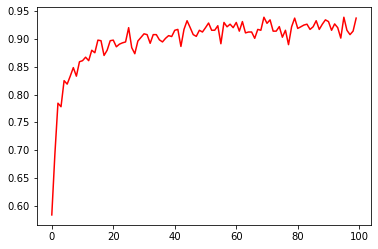

In [17]:
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('TraiN & Val Acc VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('TraiN & Val Loss VS Epochs')
plt.legend(loc=0)
plt.figure()
plt.show()

In [18]:
model.load_weights("VGG16_Model.h5")
score = model.evaluate(X_val, Y_val ,verbose=1)
print('Test Loss:', score[0])
print('Test accuracy:', score[1]*100)

6/6 [==============================] - 13s 2s/step - loss: 0.6822 - accuracy: 0.5410
Test Loss: 0.6822219491004944
Test accuracy: 54.09836173057556


Text(0.5, 1.0, 'Confusion Matrix')

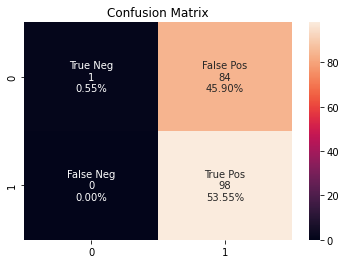

In [19]:
Y_pred = model.predict(X_val)
Y_predx = np.argmax(Y_pred, axis = -1)
Y_valx = np.argmax(Y_val, axis = -1)
cf_matrix = confusion_matrix(Y_valx, Y_predx)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot = labels, fmt = '')
plt.title("Confusion Matrix")